In [2]:
import os
os.environ['MKL_NUM_THREADS'] = '1'
import numpy as np
import numba as nb
from tqdm import tqdm
from time import time
import matplotlib.pyplot as plt

# Problem statement

We have two matrices N x N, A and B

We want to compute the matrix multiplication

## Array initialization

In [3]:
N = 1024
A = np.random.randn(N, N)
B = np.random.randn(N, N)

## Naive numba


In [4]:
@nb.njit()
def mm_numba(A, B):
    result = np.zeros((A.shape[0], B.shape[1]))
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            for k in range(A.shape[1]):
                result[i, j] += A[i, k ] * B[k, j]
    return result
        
        

In [6]:
%timeit mm_numba(A, B)

1.63 s ± 41.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Tiled numba


In [16]:
@nb.njit
def mm_tiled(A, B, TS):
    result = np.zeros((A.shape[0], B.shape[1]))
    TS = TS
    for ta_x in range(int(np.ceil(A.shape[0] / TS))):
        for ta_y in range(int(np.ceil(A.shape[1] / TS))):
            temp_A = A[ta_x * TS:(ta_x + 1) * TS, ta_y * TS : (ta_y + 1) * TS]
            tb_x = ta_y
            for tb_y in range(int(np.ceil(B.shape[1] / TS))):
                temp_B = B[tb_x * TS:(tb_x + 1) * TS, tb_y * TS : (tb_y + 1) * TS]
                output = result[ta_x * TS:(ta_x + 1) * TS, tb_y * TS : (tb_y + 1) * TS]
                for di in range(TS):
                    for dj in range(TS):
                        for dk in range(TS):
                            output[di, dj] += temp_A[di, dk] * temp_B[dk, dj]
    return result

def measure(TS):
    start = time()
    mm_tiled(A, B, TS)
    return time() - start

In [18]:
sizes = 2 ** np.arange(11)
timings = [measure(x) for x in sizes]

In [21]:
%timeit A @ B

38.2 ms ± 540 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


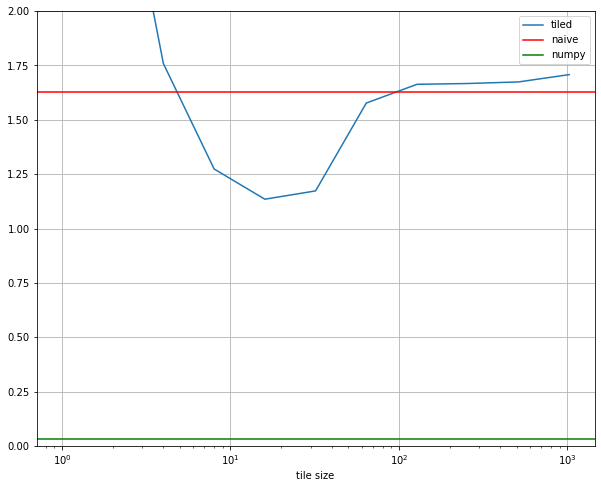

In [30]:
plt.plot(sizes, timings, label='tiled')
plt.ylim(0, 2)
plt.axhline(1.63, c='red', label='naive')
plt.axhline(0.032, c='green', label='numpy')
plt.gcf().set_size_inches(10, 8)
plt.grid()
plt.xlabel('tile size')
plt.xscale('log')
plt.legend()

# Problem statement

We have an N x N x 2 tensor.

The first two dimensions represent X and Y coordinates 
The last dimension is used to store two different attributes available for each coordinate (eg sunshing and rainfall)

Our goal is to compare the ratio of intensities of sun / rain

The formula we decided to to use is the following (for coordinates x and y)

`output[x, y] = norm(M[x-5:x+5, y-5:y+5, 0]) / norm(M[x-5:x+5, y-5:y+5, 1])`

## Array initialization

In [33]:
M = np.random.randn(4000, 4000, 2)


## Naive numba version

In [37]:
@nb.njit
def compute(M):
    result = np.zeros(M.shape[:-1])
    for x in range(5, M.shape[0] - 5):
        for y in range(5, M.shape[1] - 5):
            window = M[x - 5: x + 5, y - 5 : y + 5]
            result[x, y] = np.linalg.norm(window[0]) / np.linalg.norm(window[1])
    return result

In [38]:
%time r = compute(M)

CPU times: user 10.2 s, sys: 50.4 ms, total: 10.3 s
Wall time: 10.3 s



## Naive numba version

In [6]:
@nb.njit
def compute_reversed(M):
    result = np.zeros(M.shape[:-1])
    for x in range(5, M.shape[0] - 5):
        for y in range(5, M.shape[1] - 5):
            window = M[x - 5: x + 5, y - 5 : y + 5]
            result[x, y] = np.linalg.norm(window[0]) / np.linalg.norm(window[1])
    return result

In [7]:
%time r = compute_reversed(M)

CPU times: user 9.55 s, sys: 31.4 ms, total: 9.59 s
Wall time: 9.57 s


## Some time for you to think


.


.


A little more time

.

.

 ## Tiling

In [35]:
@nb.njit()
def chunked(array_shape, tile_size):
    result = np.empty(len(tile_size), dtype=nb.int64)
    for idx in range(len(result)):
        result[idx] = np.ceil(array_shape[idx] / tile_size[idx])
    return result

@nb.njit
def compute_tiled(M):
    TS = (16, 16)
    sizes = chunked(M.shape, TS)
    result = np.zeros(M.shape[:-1])
    
    # Iterating over tiles
    for tx in range(sizes[0]):
        for ty in range(sizes[1]):
            
            # Iterating over cells within a tile 
            for x in range(max(25, tx * TS[0]), min(M.shape[0] - 25, (tx + 1) * TS[0])):
                for y in range(max(25, ty * TS[1]), min(M.shape[1] - 25, (ty + 1) * TS[1])):
                    window = M[x - 25: x + 25, y - 25 : y + 25]
                    result[x, y] = np.linalg.norm(window[0]) / np.linalg.norm(window[1])
    return result

In [36]:
%time r = compute_tiled(M)

CPU times: user 12.7 s, sys: 35.6 ms, total: 12.7 s
Wall time: 12.7 s



## Naive numba version